In [1]:
import os

os.environ["HF_HUB_DISABLE_XET"] = "1"

In [2]:
import string

import matplotlib.pyplot as plt
import nltk
import polars as pl
import pymorphy3
import seaborn as sns
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# Загрузка датасета.

In [3]:
dataset = pl.read_csv(
    "https://github.com/sismetanin/rureviews/raw/refs/heads/master/women-clothing-accessories.3-class.balanced.csv",
    separator="\t",
)

In [4]:
dataset.head()

review,sentiment
str,str
"""качество плохое пошив ужасный …","""negative"""
"""Товар отдали другому человеку,…","""negative"""
"""Ужасная синтетика! Тонкая, нич…","""negative"""
"""товар не пришел, продавец прод…","""negative"""
"""Кофточка голая синтетика, носи…","""negative"""


In [5]:
def column_stats(df: pl.DataFrame) -> pl.DataFrame:
    """Show statistic for dataframe."""
    return pl.DataFrame(
        {
            "column": df.columns,
            "dtype": [df[col].dtype for col in df.columns],
            "non_null_count": [df[col].count() for col in df.columns],
            "null_count": [df[col].null_count() for col in df.columns],
            "unique_count": [df[col].n_unique() for col in df.columns],
        },
    )

In [6]:
column_stats(dataset)

column,dtype,non_null_count,null_count,unique_count
str,object,i64,i64,i64
"""review""",String,90000,0,87321
"""sentiment""",String,90000,0,3


<Axes: xlabel='sentiment', ylabel='Count'>

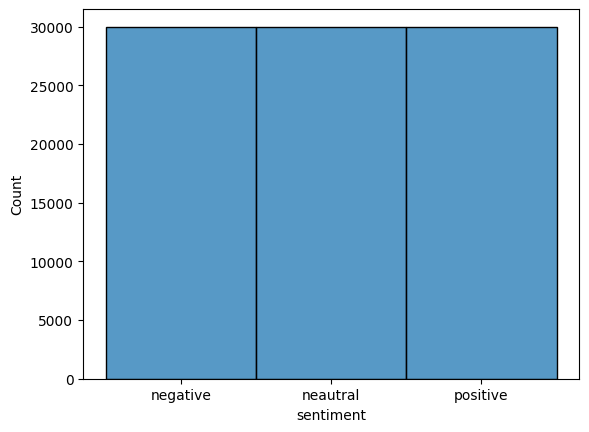

In [7]:
sns.histplot(dataset, x="sentiment")

Датасет хороший, пропусков нет, дисбаланса классов нет.

# TF-IDF

## Предобработка текста

In [8]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/pavel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/pavel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from collections.abc import Callable


def get_text_preparation_func() -> Callable[[str], list[str]]:
    """Get function for full text preparation pipeline."""
    clean_set = set(nltk.corpus.stopwords.words("russian")) | set(string.punctuation) | {str(x) for x in range(10)}
    morph = pymorphy3.MorphAnalyzer(lang="ru")

    def prepare_text(sentence: str) -> list[str]:
        tokens = nltk.word_tokenize(sentence.lower(), language="russian")
        filtered_tokens = filter(lambda token: token not in clean_set, tokens)
        return [morph.parse(token)[0].normal_form for token in filtered_tokens]

    return prepare_text

In [10]:
dataset = dataset.with_columns(
    pl.col("review")
    .map_elements(get_text_preparation_func(), return_dtype=pl.List(pl.String))
    .alias("review_prepared"),
)

In [11]:
dataset

review,sentiment,review_prepared
str,str,list[str]
"""качество плохое пошив ужасный …","""negative""","[""качество"", ""плохой"", … "".......""]"
"""Товар отдали другому человеку,…","""negative""","[""товар"", ""отдать"", … ""вернуть""]"
"""Ужасная синтетика! Тонкая, нич…","""negative""","[""ужасный"", ""синтетик"", … ""рекомендовать""]"
"""товар не пришел, продавец прод…","""negative""","[""товар"", ""прийти"", … ""обещание""]"
"""Кофточка голая синтетика, носи…","""negative""","[""кофточка"", ""голый"", … ""возможно""]"
…,…,…
"""сделано достаточно хорошо. на …","""positive""","[""сделать"", ""достаточно"", … ""месяц""]"
"""Накидка шикарная. Спасибо боль…","""positive""","[""накидка"", ""шикарный"", … ""спасибо""]"
"""спасибо большое ) продовца рек…","""positive""","[""спасибо"", ""большой"", … ""12.09""]"


In [36]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x,
    token_pattern=None,
    ngram_range=(1, 2),
    max_features=5000,
    norm="l2",
)

In [37]:
tfdf_mat = vectorizer.fit_transform(dataset["review_prepared"])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    tfdf_mat,
    dataset["sentiment"].to_numpy(),
    test_size=0.25,
    random_state=42,
    stratify=dataset["sentiment"].to_numpy(),
)

In [60]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [61]:
print(clf.classes_)

['neautral' 'negative' 'positive']


              precision    recall  f1-score   support

    neautral       0.61      0.63      0.62      7500
    negative       0.72      0.70      0.71      7500
    positive       0.85      0.84      0.84      7500

    accuracy                           0.72     22500
   macro avg       0.72      0.72      0.72     22500
weighted avg       0.72      0.72      0.72     22500



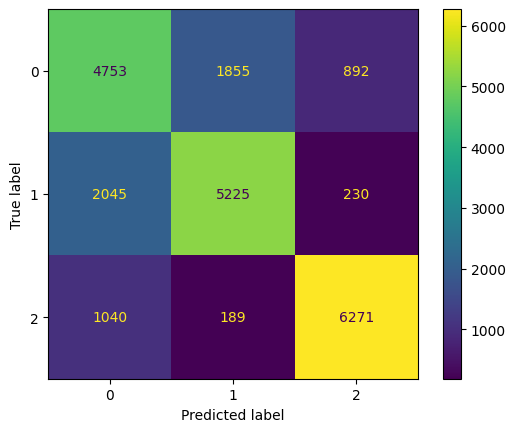

In [62]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

В целом получились не плохие результаты, чаще всего модель путает нейтральный и негативные классы, это видно как на графиках так и в отчете. Точность и полнота для позитивного класса 85% и 84% соответственно. Для негативного 72% и 70%. И для нейтрального 61% 63%.

In [ ]:
cbclf = CatBoostClassifier()
cbclf.fit(X_train, y_train)

Learning rate set to 0.098088
0:	learn: 1.0656451	total: 537ms	remaining: 8m 56s
1:	learn: 1.0396984	total: 938ms	remaining: 7m 47s
2:	learn: 1.0187553	total: 1.33s	remaining: 7m 22s
3:	learn: 1.0017848	total: 1.74s	remaining: 7m 12s
4:	learn: 0.9868635	total: 2.13s	remaining: 7m 4s
5:	learn: 0.9737568	total: 2.53s	remaining: 6m 58s
6:	learn: 0.9618274	total: 2.95s	remaining: 6m 58s
7:	learn: 0.9528797	total: 3.35s	remaining: 6m 55s
8:	learn: 0.9443096	total: 3.76s	remaining: 6m 53s
9:	learn: 0.9355017	total: 4.15s	remaining: 6m 50s
10:	learn: 0.9274805	total: 4.54s	remaining: 6m 48s
11:	learn: 0.9201788	total: 4.94s	remaining: 6m 47s
12:	learn: 0.9139902	total: 5.34s	remaining: 6m 45s
13:	learn: 0.9076954	total: 5.73s	remaining: 6m 43s
14:	learn: 0.9020230	total: 6.13s	remaining: 6m 42s
15:	learn: 0.8969364	total: 6.51s	remaining: 6m 40s
16:	learn: 0.8920995	total: 6.91s	remaining: 6m 39s
17:	learn: 0.8874693	total: 7.33s	remaining: 6m 39s
18:	learn: 0.8830338	total: 7.74s	remaining: 

              precision    recall  f1-score   support

    neautral       0.60      0.66      0.63      7500
    negative       0.73      0.69      0.71      7500
    positive       0.84      0.81      0.82      7500

    accuracy                           0.72     22500
   macro avg       0.73      0.72      0.72     22500
weighted avg       0.73      0.72      0.72     22500



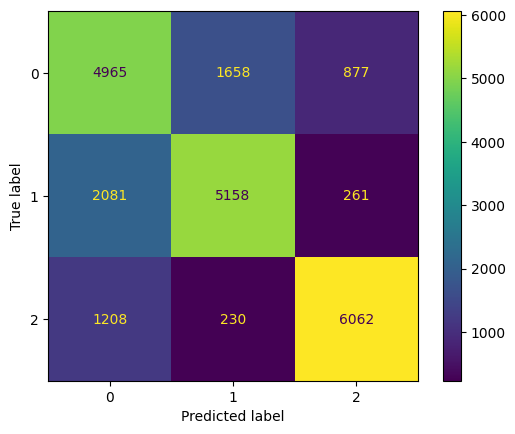

In [65]:
y_pred2 = cbclf.predict(X_test)
print(classification_report(y_test, y_pred2))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred2)).plot()
plt.show()

Неожиданно, но метрики получились даже чуть хуже чем у линейной регрессии.

# ruBERT

In [12]:
model = SentenceTransformer("cointegrated/rubert-tiny2")

In [13]:
text = dataset["review"].to_numpy()
bert_embeddings = model.encode(text, normalize_embeddings=True)

In [14]:
X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(
    bert_embeddings,
    dataset["sentiment"].to_numpy(),
    test_size=0.25,
    random_state=42,
    stratify=dataset["sentiment"].to_numpy(),
)

In [15]:
bert_emb_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
bert_emb_clf.fit(X_emb_train, y_emb_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


              precision    recall  f1-score   support

    neautral       0.61      0.62      0.62      7500
    negative       0.71      0.70      0.71      7500
    positive       0.83      0.82      0.83      7500

    accuracy                           0.72     22500
   macro avg       0.72      0.72      0.72     22500
weighted avg       0.72      0.72      0.72     22500



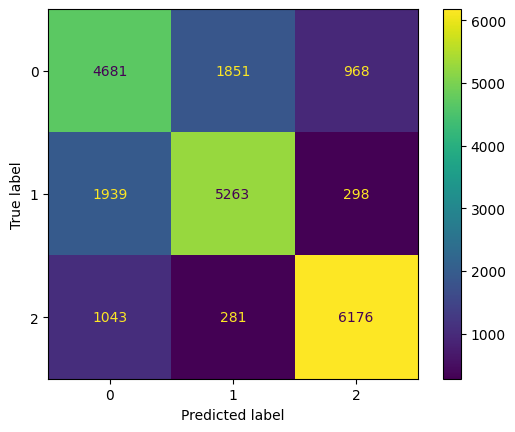

In [16]:
y_emb_pred = bert_emb_clf.predict(X_emb_test)
print(classification_report(y_emb_test, y_emb_pred))
ConfusionMatrixDisplay(confusion_matrix(y_emb_test, y_emb_pred)).plot()
plt.show()

In [17]:
bert_emb_cbclf = CatBoostClassifier()
bert_emb_cbclf.fit(X_emb_train, y_emb_train)

Learning rate set to 0.098088
0:	learn: 1.0590301	total: 161ms	remaining: 2m 40s
1:	learn: 1.0280876	total: 235ms	remaining: 1m 57s
2:	learn: 0.9995384	total: 308ms	remaining: 1m 42s
3:	learn: 0.9752283	total: 389ms	remaining: 1m 36s
4:	learn: 0.9540562	total: 458ms	remaining: 1m 31s
5:	learn: 0.9355558	total: 529ms	remaining: 1m 27s
6:	learn: 0.9190691	total: 599ms	remaining: 1m 24s
7:	learn: 0.9047228	total: 674ms	remaining: 1m 23s
8:	learn: 0.8912203	total: 745ms	remaining: 1m 22s
9:	learn: 0.8786784	total: 815ms	remaining: 1m 20s
10:	learn: 0.8671010	total: 880ms	remaining: 1m 19s
11:	learn: 0.8568592	total: 955ms	remaining: 1m 18s
12:	learn: 0.8475960	total: 1.02s	remaining: 1m 17s
13:	learn: 0.8390942	total: 1.09s	remaining: 1m 16s
14:	learn: 0.8307694	total: 1.16s	remaining: 1m 16s
15:	learn: 0.8239409	total: 1.22s	remaining: 1m 15s
16:	learn: 0.8163816	total: 1.29s	remaining: 1m 14s
17:	learn: 0.8099321	total: 1.36s	remaining: 1m 14s
18:	learn: 0.8039210	total: 1.44s	remaining:

              precision    recall  f1-score   support

    neautral       0.61      0.64      0.62      7500
    negative       0.72      0.69      0.70      7500
    positive       0.84      0.82      0.83      7500

    accuracy                           0.72     22500
   macro avg       0.72      0.72      0.72     22500
weighted avg       0.72      0.72      0.72     22500



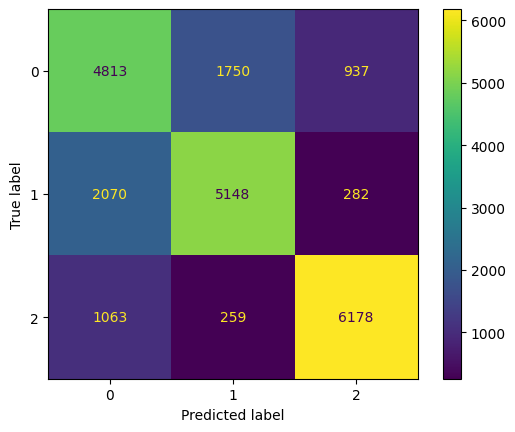

In [18]:
y_emb_pred = bert_emb_cbclf.predict(X_emb_test)
print(classification_report(y_emb_test, y_emb_pred))
ConfusionMatrixDisplay(confusion_matrix(y_emb_test, y_emb_pred)).plot()
plt.show()

Между логистической регрессией и бустингом нет особой разницы в метриках, как и в методе tf-idf и эмбеддингами rubert. Скорее всего достигается почти максимум по возможностями классификации в этом датасете. В целом отделить и понять когда человек нейтрален и негативен сложнее всего, что и видно на метриках.

# Сводная таблица с метриками

|Модель         |neautral (precision/recall/f1)|negative (precision/recall/f1)|positive (precision/recall/f1)|
|---------------|---------------|---------------|--------|
|tf-idf logistic|0.61/0.63/0.62|0.72/0.70/0.71|0.85/0.84/0.84|
|tf-idf catboost|0.60/0.66/0.63|0.73/0.69/0.71|0.84/0.81/0.82|
|rubert logistic|0.61/0.62/0.62|0.71/0.70/0.71|0.83/0.82/0.83|
|rubert catboost|0.61/0.64/0.62|0.72/0.69/0.70|0.84/0.82/0.83|
